*updated 18 Jan 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 3301 "Data Analysis in Ocean Sciences" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/academic-notes/tree/master/OCES3301_data_analysis_ocean) page.

In [1]:
# load some deafult packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

---------------------------

# 04: (multi-)linear regression and others

Here we are going to touch on a selection of useful tools for dealing with higher dimensional data that are somewhat commonly encountered. For this bit I found it slightly unsatisfactory using the artificial data I attempted to create (I tried a bit but not that hard...), so we are actually going to use the Iris data in `iris.csv` (touched up slightly from the raw download at [UCL repository](https://archive.ics.uci.edu/ml/datasets/iris)).

-----------------------------
# a) multi-linear regression

Recall linear regression as visited last time is that, given some input data $x_i$ and output data $y_i$, you find the $a$ and $b$ values in $y = f(x) = ax + b$ such that some measure of mismatch is minimised; generally we look for the $\ell_2$ minimiser, i.e. values of $a$ and $b$ where the mean squared error $\sum (f(x_i) - y_i)^2$ is minimised. Beyond linear regression, we can fit quadratics, cubics etc., with increasing the number of coefficients.

There is of course no stopping you increasing the number of inputs instead, so you could have

\begin{equation*}
    y = f(x, w, v, u, \ldots) = ax + bw + cv + du + \ldots + {\rm constant} = C + \sum_{j=1}^N a_j x_j,
\end{equation*}

where you are looking for the coefficients $a_j$ and constant $C$ that minimises the mismatch $(y_i - f(x_{i,j})^2$ for given variable $x_j$ and sample value of that type $x_{i,j}$. This would be **multi-linear regression**, "multi* because the number of variables is more than 1, and "linear" because everything is kept at the linear level. A concrete example could be

\begin{equation*}
    {\rm cursedness} = a \times {\rm size} + b \times {\rm distortion} + c \times {\rm Eldritch\ attribute} + d \times {\rm colour} + \ldots
\end{equation*}

<img src="https://i.kym-cdn.com/photos/images/newsfeed/001/657/476/0da" width="400" alt='Eldritch horror'>

Note here that there is a **single** output (we are not going to touch on **multi-variate regression** here). One could in principle add more complexity (either as number of input variables, or functional dependence), but you should bear in mind that this can lead to over-fitting; see *03_regression* for how this could cause problems.

> NOTE: ***again, I cannot stress this enough, regression by default gives you correlations, and correlations do not ncessarily imply causations***. Anyone who over-claims in this course will incur the wrath of cathulu and have credit deducted from their assignments.

## step -1: have a look at the data first

Lets do this with the penguin data. Again, we should probably have a look the data first (https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/penguins.csv). Below is just the code to read the Penguin data in Pandas, and is the same one as *02_reading_data*. You could always also look up the raw data file itself too, since this is a text file that you could just open with your favourite text editor.

<img src="https://www.boredpanda.com/blog/wp-content/uploads/2020/08/cats-standing-like-penguins-fb-png__700.jpg" width="500" alt='cursed penguins'>

In [2]:
option = "local"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

print("===============================")
print("sample of data")
print("===============================")
print(df.sample(10))
print()
print("===============================")
print("some basic statistics from data")
print("===============================")
print(df.describe())

# slice out one of the species and have a look at the basic statistics
adelie_data = df.loc[df["species"] == "Adelie"]

loading data locally (assumes file has already been downloaded)
sample of data
       species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
45      Adelie            41.1           19.0              182.0       3425.0
173     Gentoo            46.5           14.5              213.0       4400.0
176     Gentoo            46.1           15.1              215.0       5100.0
28      Adelie            40.5           18.9              180.0       3950.0
26      Adelie            40.5           17.9              187.0       3200.0
126     Adelie            41.5           18.3              195.0       4300.0
288  Chinstrap            45.9           17.1              190.0       3575.0
334  Chinstrap            51.9           19.5              206.0       3950.0
20      Adelie            37.7           18.7              180.0       3600.0
193     Gentoo            45.3           13.7              210.0       4300.0

some basic statistics from data
       bill_length_mm  bill_de

In [3]:
adelie_data

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,36.7,19.3,193.0,3450.0
4,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
146,Adelie,36.6,18.4,184.0,3475.0
147,Adelie,36.0,17.8,195.0,3450.0
148,Adelie,37.8,18.1,193.0,3750.0
149,Adelie,36.0,17.1,187.0,3700.0


To add a bit more content, here are some **pair plots** of the variables with the iris data that I did by hand. Have a see what you think these are doing.

> NOTE: You can do the below in one line and with a much nicer result in the `seaborn` package.

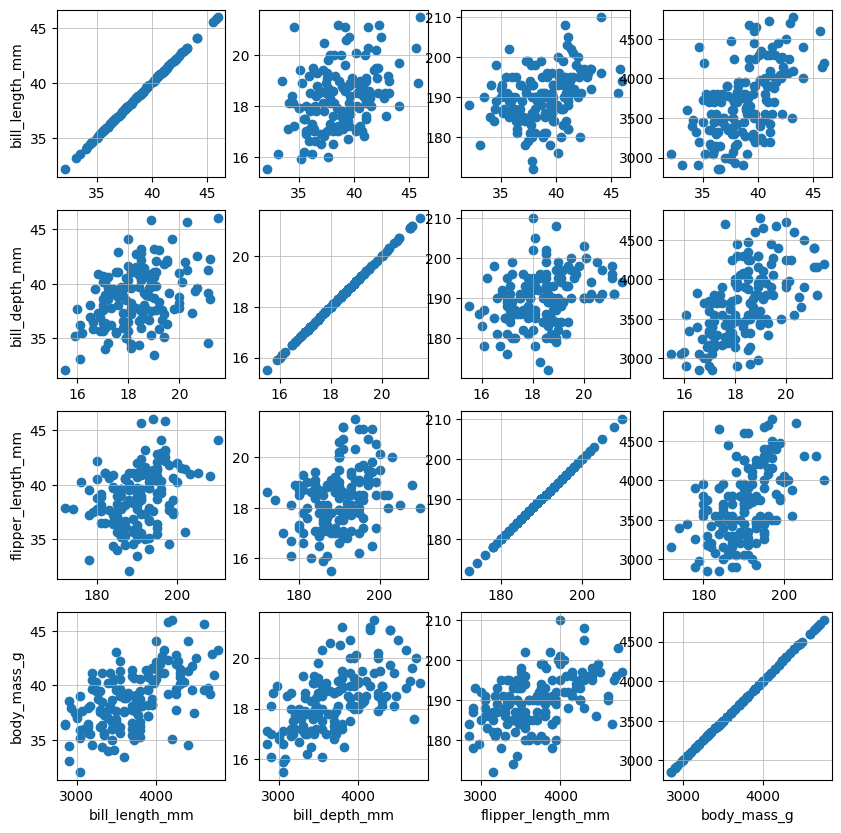

In [4]:
fig = plt.figure(figsize=(10, 10))
count = 0
for i in range(1, len(adelie_data.columns[0::])):
    for j in range(1, len(adelie_data.columns[0::])):
        count += 1
        ax = plt.subplot(4, 4, count)
        ax.scatter(adelie_data[adelie_data.columns[i]], adelie_data[adelie_data.columns[j]])
        ax.grid(lw=0.5, zorder=0)
        if j == 1:
            ax.set_ylabel(adelie_data.columns[i])
        if i == len(adelie_data.columns[0::])-1:
            ax.set_xlabel(adelie_data.columns[j])

> <span style="color:red">**Q.**</span> Describe the code above and explain what it is doing.

> <span style="color:red">**Q.**</span> Why are there 16 plots? Also, of the 16 plots, only 6 of these are actually conveying new information, which ones, and why?

> <span style="color:red">**Q.**</span> For the 6 plots that actually convey new information, do a linear regression on these pairs, and put line of best fit as well as write in the $r$-values on the plot (do it however you wish)

The below is some Pandas command to compute some relevant correlation coefficients. We will do a few more of these in *05/06_statistical_tests*.

> <span style="color:red">**Q.**</span> Check the Pandas outputs against the ones you did by hand just and make sure they are the same (or, if they are not the same, chase up on why they are not the same).

In [5]:
print("===============================")
print("Pearson correlation")
print("===============================")
print(df.corr(method="pearson", numeric_only = True))  # warning if "numeric_only" not specified
print()
print("===============================")
print("Spearman correlation")
print("===============================")
print(df.corr(method="spearman", numeric_only = True))

Pearson correlation
                   bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm           1.000000      -0.235053           0.656181   
bill_depth_mm           -0.235053       1.000000          -0.583851   
flipper_length_mm        0.656181      -0.583851           1.000000   
body_mass_g              0.595110      -0.471916           0.871202   

                   body_mass_g  
bill_length_mm        0.595110  
bill_depth_mm        -0.471916  
flipper_length_mm     0.871202  
body_mass_g           1.000000  

Spearman correlation
                   bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm           1.000000      -0.221749           0.672772   
bill_depth_mm           -0.221749       1.000000          -0.523267   
flipper_length_mm        0.672772      -0.523267           1.000000   
body_mass_g              0.583800      -0.432372           0.839974   

                   body_mass_g  
bill_length_mm        0.583800  
bill_depth_mm  

## step 0: look at the data but the data of interest

Suppose from step -1 above you decided that ***body mass*** is the variable you want to predict, and you think you can predict the bill length with data related to the ***bill***. We are only going to just do this for the *Adelie* data for now.

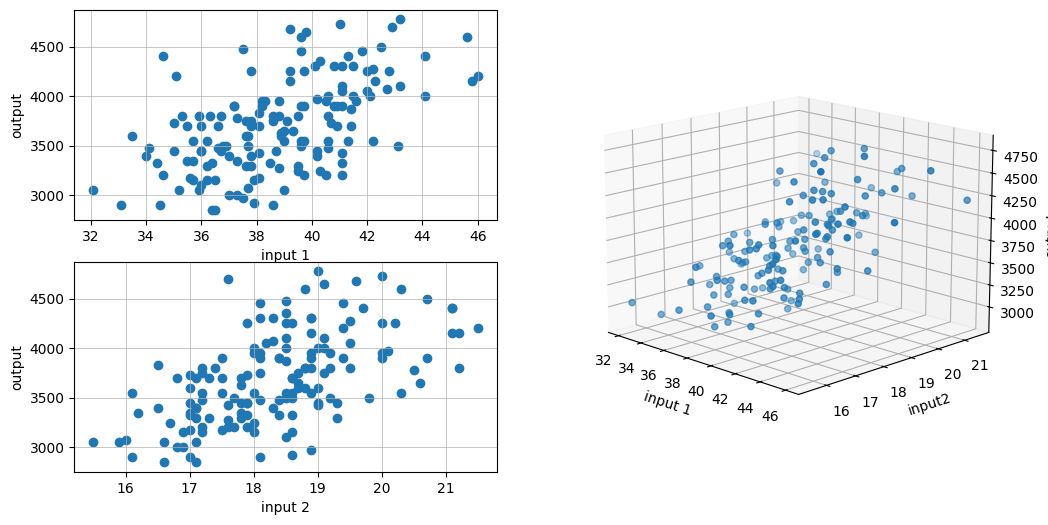

In [6]:
input_var = adelie_data[['bill_length_mm', 'bill_depth_mm']].values
output_var = adelie_data['body_mass_g'].values

fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(2, 2, 1)
ax.scatter(input_var[:, 0], output_var)
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"output"); ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(2, 2, 3)
ax.scatter(input_var[:, 1], output_var)
ax.set_xlabel(r"input 2"); ax.set_ylabel(r"output"); ax.grid(lw=0.5, zorder=0)

ax = plt.subplot2grid([2, 2], [0, 1], rowspan=2, colspan=1, projection="3d")
ax.scatter(input_var[:, 0], input_var[:, 1], output_var)
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"input2"); ax.set_zlabel(r"output"); ax.grid(lw=0.5, zorder=0)
ax.view_init(15, -45)

> <span style="color:red">**Q.**</span> Before you really go into stuff you should think about whether something might work or not. So with the graph above, can you say why the procedure below might actually work that well? Could you have anticipated this with information further above?

We could do the regression in raw `numpy` and `scipy`, but we are just going to leverage the `sklearn.linear_model` package, which generically gives you a linear regression for arbitrary number of inputs (so it includes the straight forward linear regression as a special case). 

The syntax is below, where I use both the bill attributes as inputs and the body mass as output. Once I've fit the model, I get the parameters I need, and I could throw the input values back in to get a **predicted value** to see how well I do compared to the actual data value, which are also given below.

> NOTE: The below syntax is good for doing the predictions one at a time (controlled through the `ind` variable), and you can play around with this and see what you get.

In [7]:
from sklearn import linear_model

lin_regr = linear_model.LinearRegression() # initialise class

input_var = adelie_data[['bill_length_mm', 'bill_depth_mm']].values
output_var = adelie_data['body_mass_g'].values

lin_regr.fit(input_var, output_var)        # do multilinear fitting

# the lin_regr is now your model of y = c + \Sum a_i * X_i, pull out the coefficients a_i
s, c = lin_regr.coef_, lin_regr.intercept_  # (s, c) interpretation as before, see lec03 notebook
                                            # the s ar the (linear) trends
print(f"suggested model is y = {c:.4f} + {s[0]:.4f} * x_1 + {s[1]:.4f} * x_2")
print(f"   r^2 value is {lin_regr.score(input_var, output_var):.4f}")  # suggestion of fit

ind = 0
pred_out = lin_regr.predict([[input_var[ind, 0], input_var[ind, 1]]])
print(f"input1 = {input_var[ind, 0]}, input2 = {input_var[ind, 1]}, actual value = {output_var[ind]}, pred value = {pred_out[0]}")

suggested model is y = -1799.8108 + 65.7416 * x_1 + 160.8093 * x_2
   r^2 value is 0.4554
input1 = 39.1, input2 = 18.7, actual value = 3750.0, pred value = 3777.819710982437


> <span style="color:red">**Q.**</span> What does the $r$-squared value mean? And given the $r$-squared value, how well do you expect the regression model to perform generally?

Below is syntax to make the prediction over the range of entries we have, and dumping it back into a Pandas array for easier comparison in a table, as well as plotting the predictions out.

In [8]:
adelie_data_mod = adelie_data.copy(deep=True)

# make a prediction
N = input_var.shape[0]
pred_out = np.zeros(N)
for ind in range(N):
    pred_out[ind] = lin_regr.predict([[input_var[ind, 0], input_var[ind, 1]]])[0]

# now have an array of predicted values, put this into pandas to read
# syntax: df["whatever you want to call the column"] = data_array
adelie_data_mod["pred.body_mass_g"] = pred_out
adelie_data_mod["signed mismatches"] = pred_out - adelie_data_mod["body_mass_g"]
adelie_data_mod["squared mismatch"] = (pred_out - adelie_data_mod["body_mass_g"]) ** 2
adelie_data_mod.sample(10).style.set_properties(**{'background-color': 'pink'}, 
                                     subset=['pred.body_mass_g', 'signed mismatches', 'squared mismatch'])

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,pred.body_mass_g,signed mismatches,squared mismatch
128,Adelie,44.100000,18.000000,210.000000,4000.000000,3993.961085,-6.038915,36.468495
103,Adelie,37.900000,18.600000,193.000000,2925.000000,3682.848879,757.848879,574334.922978
43,Adelie,37.000000,16.900000,185.000000,3000.000000,3350.305581,350.305581,122713.999904
112,Adelie,42.200000,19.500000,197.000000,4275.000000,4110.266086,-164.733914,27137.262559
37,Adelie,37.600000,19.300000,181.000000,3300.000000,3775.692940,475.692940,226283.773635
39,Adelie,36.500000,18.000000,182.000000,3150.000000,3494.325061,344.325061,118559.747763
84,Adelie,41.300000,20.300000,194.000000,3550.000000,4179.746132,629.746132,396580.190621
104,Adelie,39.700000,18.900000,184.000000,3550.000000,3849.426528,299.426528,89656.245532
140,Adelie,40.600000,17.200000,187.000000,3475.000000,3635.218078,160.218078,25669.832369
49,Adelie,39.600000,17.700000,186.000000,3500.000000,3649.881164,149.881164,22464.363416


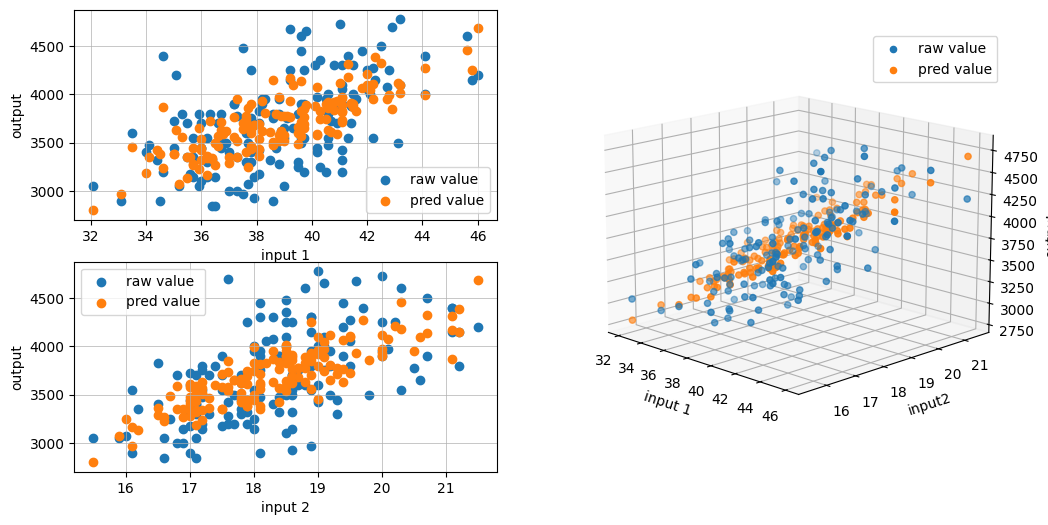

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(2, 2, 1)
ax.scatter(input_var[:, 0], output_var, label="raw value")
ax.scatter(input_var[:, 0], adelie_data_mod["pred.body_mass_g"], label="pred value")
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"output"); ax.grid(lw=0.5, zorder=0); ax.legend();

ax = plt.subplot(2, 2, 3)
ax.scatter(input_var[:, 1], output_var, label="raw value")
ax.scatter(input_var[:, 1], adelie_data_mod["pred.body_mass_g"], label="pred value")
ax.set_xlabel(r"input 2"); ax.set_ylabel(r"output"); ax.grid(lw=0.5, zorder=0); ax.legend();

ax = plt.subplot2grid([2, 2], [0, 1], rowspan=2, colspan=1, projection="3d")
ax.scatter(input_var[:, 0], input_var[:, 1], output_var, label="raw value")
ax.scatter(input_var[:, 0], input_var[:, 1], adelie_data_mod["pred.body_mass_g"], label="pred value")
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"input2"); ax.set_zlabel(r"output"); ax.grid(lw=0.5, zorder=0); ax.legend();
ax.view_init(15, -45)

> <span style="color:red">**Q.**</span> Are the prediction skill (or lack or) consistent with the information so far?

> <span style="color:red">**Q.**</span> Try this with different combinations of attributes, or use data from different species, as form of practice and to see if certain attributes work better. You could also try including more inputs (but see below exercise).

> <span style="color:red">**Q.**</span> (technical) Work out how you can get rid of the `for` loop above for the predicton step and just pass in an array so that the model can give the predictions with one single call.

> <span style="color:red">**Q.**</span> (technical) Python usually makes `soft` copies, and I overrode that with the command `DATA_FRAME.copy(deep=True)`. Look up the difference between soft and hard copying in Python and convince yourself why in this case you might want a deep copy instead. Provide a simple demonstration on the effects of soft copying.

--------------------

# b) A/BIC: mismatch vs. complexity

So lets suppose we repeat the above multi-linear regression for setosa data for simplicity, and we are still interested in predicting the petal length. We could construct a variety of ensembles and evalute its *skill* through their ability to reduce mismatches.

The code below "trains" up four models with multi-linear regression, and computes the $\ell_2$ mismatches.

> NOTE: I am using all the data, and sometimes when regressing / training a model you don't want to do that, because you want some data left over to evaluate model performance. Here I am delibrately not doing this to make a point and to keep everything deterministic (separating out training and testing data is normally random / stochastic).

In [10]:
output_var = adelie_data['body_mass_g'].values

N = len(output_var)

# train up a variety of models

input_var = adelie_data[['flipper_length_mm']].values
model1 = linear_model.LinearRegression()
model1.fit(input_var, output_var)
num_coeff1 = len(model1.coef_)+1  # Q. why +1?
pred1 = model1.predict(input_var)
var1 = np.sum((pred1 - output_var) ** 2) / N

input_var = adelie_data[['flipper_length_mm', 'bill_length_mm']].values
model2 = linear_model.LinearRegression()
model2.fit(input_var, output_var)
num_coeff2 = len(model2.coef_)+1
pred2 = model2.predict(input_var)
var2 = np.sum((pred2 - output_var) ** 2) / N

input_var = adelie_data[['flipper_length_mm', 'bill_length_mm', 'bill_depth_mm']].values
model3 = linear_model.LinearRegression()
model3.fit(input_var, output_var)
num_coeff3 = len(model3.coef_)+1
pred3 = model3.predict(input_var)
var3 = np.sum((pred3 - output_var) ** 2) / N

input_var = adelie_data[['bill_depth_mm']].values
model4 = linear_model.LinearRegression()
model4.fit(input_var, output_var)
num_coeff4 = len(model4.coef_)+1
pred4 = model4.predict(input_var)
var4 = np.sum((pred4 - output_var) ** 2) / N

print(f"error variance (mean squared error) for model 1 is {var1:.6f}, number of coeffs = {num_coeff1}")
print(f"error variance (mean squared error) for model 2 is {var2:.6f}, number of coeffs = {num_coeff2}")
print(f"error variance (mean squared error) for model 3 is {var3:.6f}, number of coeffs = {num_coeff3}")
print(f"error variance (mean squared error) for model 4 is {var4:.6f}, number of coeffs = {num_coeff4}")

error variance (mean squared error) for model 1 is 163098.859029, number of coeffs = 2
error variance (mean squared error) for model 2 is 126390.345948, number of coeffs = 3
error variance (mean squared error) for model 3 is 102733.155757, number of coeffs = 4
error variance (mean squared error) for model 4 is 139552.252290, number of coeffs = 2


> <span style="color:red">**Q.**</span> Go through the code and describe how are the models different.

> <span style="color:red">**Q.**</span> Suppose you evaluate model performance instead using the sum of the absolute errors instead, is the result the same?

Just from evaluating model skill you would think in this case the third model is the best since that has the lowest $\ell_2$ mismatch. One could however argue this is cheating somewhat, because model 3 has the most complexity with more input variables than the rest, and thus susceptible to over-fitting effects. A goal here might be to find the simplest model that is the most skillful in some sense, which would indicate the input you chose are particularly **strong predictor** for the variable in question.

We could evaluate the skill of a model by its ability to reduce mismatches but penalising the complexity. Two common ways for doing this with statistical models is the **Aikake Information Criterion (AIC)** and the **Bayesian Information Criterion (BIC)** (or sometimes the **Schwarz Information Criterion**), that are based on information and probability theory. For the number of parameter $k$, the sample size $N$ and the (unadjusted) error variance $\sigma^2 = \ell_2 / N$, we have respectively (taking $\log$ to mean $\log_n = \ln$, log with the natural base $\mathrm{e}$)

\begin{equation*}
    {\rm AIC} = 2k + N\log\sigma^2, \qquad {\rm BIC} = k\log N + N\log\sigma^2.
\end{equation*}

The higher the mismatch, the larger the A/BIC (because both scale with $\log\sigma^2$ and the $\log$ function is monotonically increasing), while the lower the complexity as measured by $k$, the smaller the A/BIC. The lower the AIC or BIC, the "better" the model is, so provides a means for model selection.

> NOTE: A/BIC only gives you the choice to compare between different models trained with the **same** data really. For example, a model of Iris with a lower AIC score compare to the model of cursedness of animal say of the above does not mean anything by itself, because it is not really comparing like for like.

> NOTE: If you look up the standard definition of AIC and BIC you will see it is $-2\log \hat{L}$ instead, which is the **log-likelihood**. Here I have assumed Gaussian statistics (see *05_statistical_tests*), so I know the likelihood function $\hat{L}$, and can manipulate the expression to something I already have data for.

> NOTE: I am also probably off by 1 in how I am going to count $k$ (because I should probably count the stochasticity as an extra parameter), and there are some multiplicative factors missing from above note, but at least I am consistently wrong here (so it doesn't matter since A/BIC are really relative measures)...

The below code provides subroutines for A/BIC and applies it to the models above.

In [11]:
def calc_aic(k, variance, N):
    aic = 2 * k         + N * np.log(variance)
    return aic

def calc_bic(k, variance, N):
    bic = k * np.log(N) + N * np.log(variance)
    return bic

print("===============================")
print("AIC of models")
print("===============================")
print(f"model 1: AIC = {calc_aic(N, var1, num_coeff1):.6f}")
print(f"model 2: AIC = {calc_aic(N, var2, num_coeff2):.6f}")
print(f"model 3: AIC = {calc_aic(N, var3, num_coeff3):.6f}")
print(f"model 4: AIC = {calc_aic(N, var4, num_coeff4):.6f}")
print()
print("===============================")
print("BIC of models")
print("===============================")
print(f"model 1: BIC = {calc_bic(N, var1, num_coeff1):.6f}")
print(f"model 2: BIC = {calc_bic(N, var2, num_coeff2):.6f}")
print(f"model 3: BIC = {calc_bic(N, var3, num_coeff3):.6f}")
print(f"model 4: BIC = {calc_bic(N, var4, num_coeff4):.6f}")

# so from these measures, model 4 is actually the best

# Q. try these things for different combinations of variables and/or species of flowers

AIC of models
model 1: AIC = 326.004224
model 2: AIC = 337.241391
model 3: AIC = 348.159561
model 4: AIC = 325.692389

BIC of models
model 1: BIC = 128.669448
model 2: BIC = 201.131847
model 3: BIC = 255.490009
model 4: BIC = 128.357613


Here, both AIC and BIC suggests model 4 is actually the best out of the four. This quantities are only indicative, so some judgement has to be made to which models to use.

> <span style="color:red">**Q.**</span> When in doubt which one to use, compute both to give yourself a second opinion (AIC is normally used I think).

> <span style="color:red">**Q.**</span> I haven't been exhaustive in the choice of variables input/output, try a few of these yourself.

--------------------------

# c) Principal Component Analysis (PCA)

Last one we are going to deal with, and it is related to A/BIC in the sense that you want to try and pick out the *most important* feautres in a dataset, whatever "most important" actually means. 

A common way to do is to carry out a **principal compoent analysis (PCA)**, where you are essentially trying to select most important features (the **principal components (PC)**) ranked by the **variance explained**. This is useful for preliminary data exploration, for reducing the dimension of data, to see basic trends and/or clustering of data, and can also be used for scrambling the dataset for confidentiality reasons etc. 

Picking out the most important features might be of particular interest when modelling, such as statistical modelling and/or machine learning, where you don't want to have a model that is overly complex (and more susceptible to over-fitting), but still want to capture the essence of the data. The example below shows how PCAs could be applied onto pictures of cats and dogs (right, first 4 PCs of data; from Fig 10 of [Brunton, Brunton, Proctor & Kutz (2013)](https://arxiv.org/pdf/1310.4217.pdf)), picking out features that are common to both (resulting in some cursed catdogs?), which has applications in image recognition for example.

<img src="https://i.imgur.com/D5TJanm.png" width="800" alt='brunton_et_al_13_fig10'>

We will first go through what PCA actually does for a trivial example in two dimensions (so with two variables), demonstrating what the PCA is actually doing for a trivial case of projection onto one dimension, before applying it to the full Iris data (which is four dimensional data, in the sense that there are four attributes with numerical values that are documented).

> NOTE: We are going to revisit the point about decomposing and projecting data again in *07_time_series* when dealing with the Fourier basis, and in *10_fun_with_maps* when we are dealing with **Empricial Orthogonal Functions (EOFs)** for spatial-temporal data (which is closely related to PCs). Look ahead a bit if you like, or Wikipedia can help you.

PCA is when you find the a combination of variables such that the variance explained is maximised. For the iris data, while the data collected is ***sepal*** and ***petal*** data, it might be that some weird combination of (say) ***se-pe*** and ***pal-tal*** is in fact better at capturing the essence of data. The former are the original variables, while the latter would be the **principal components**. 

If you are willing to believe in mathemagics, the code below explains visually what is happening somewhat: you are essentially trying to find an ellipsoid of sorts that "minimallly" encompasses the data. You can then take the ellipsoid axis as the new axis (spanned by the principal components essentially) and transform the data into something that is circular in the new space. You could do this in raw `numpy` (see exercise below), but I am just going to use the one in `sklearn` to do it.

> NOTE: Those with maths background, you are defining a new orthogonal basis spanned by the eigenvectors of the covariance matrix (which is necessarily symmetric). The transformed covariance matrix in the new basis is diagonal and the eigenvalues are the variance explained, ranked accordingly by magnitude; ranking is guaranteed, because the matrix is real and symmetric (so is Hermitian), and thus have real eigenvalues.

## from 2d to 2d

The code below does a PCA for two variables, with 2 PCs, which will essentially going to be a rotation and stretch of the data to make it circular in the PC co-oridinates. While you get a more covenient representation of data that is as circular as possible in a sense, you lose the interpretability because the PCs don't necessarily correspond to things that are that obvious (since it is some combination of the original variables, in this case `sepal.length` and `sepal.width`.

I didn't normalise the data (and you should; see next code cell).

pca components    = [[ 0.97755919  0.21066095]
 [-0.21066095  0.97755919]]
pca var explained = [7.3671051  1.20685693]


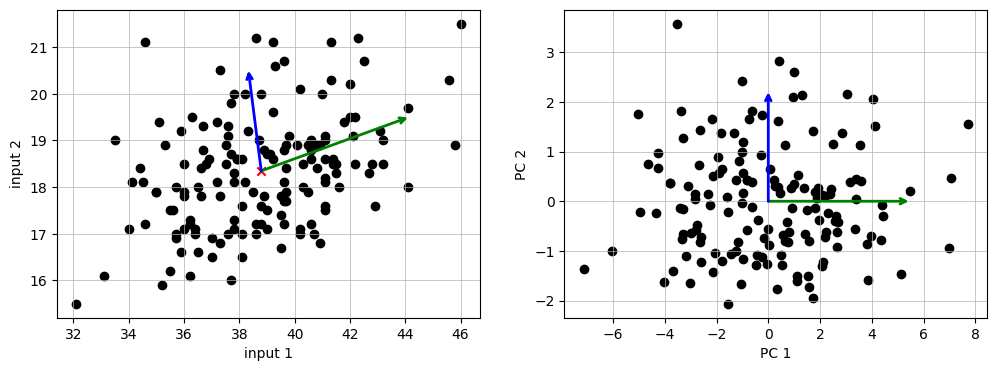

In [12]:
input_var = adelie_data[['bill_length_mm', 'bill_depth_mm']].values

from sklearn.decomposition import PCA
pca = PCA(n_components=2)   # define a PCA object with two PCAs (can choose more for larger data)
pca.fit(input_var)

print(f"pca components    = {pca.components_}")
print(f"pca var explained = {pca.explained_variance_}")

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.scatter(input_var[:, 0], input_var[:, 1], c='k')
ax.scatter(pca.mean_[0], pca.mean_[1], c='r', marker='x')
ax.annotate("", pca.mean_ + pca.components_[0] * 2 * np.sqrt(pca.explained_variance_[0]), pca.mean_,
            arrowprops=dict(color="green", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.annotate("", pca.mean_ + pca.components_[1] * 2 * np.sqrt(pca.explained_variance_[1]), pca.mean_,
            arrowprops=dict(color="blue", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"input 2"); ax.grid(lw=0.5, zorder=0)

input_pca = pca.transform(input_var)

ax = plt.subplot(1, 2, 2)
ax.scatter(input_pca[:, 0], input_pca[:, 1], c="k")
ax.annotate("", [2 * np.sqrt(pca.explained_variance_[0]), 0], [0, 0],
            arrowprops=dict(color="green", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.annotate("", [0, 2 * np.sqrt(pca.explained_variance_[1])], [0, 0],
            arrowprops=dict(color="blue", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.set_xlabel(r"PC 1"); ax.set_ylabel(r"PC 2"); ax.grid(lw=0.5, zorder=0)

The PCA components above tell you the combination of input 1 and 2 you should take to define the PCs. The variance explained is the *raw* value of the variance; in this case PC1 explains most of the variance, while PC2 not so much (which may not be surprising when you look at the green arrow on the left plot and the shape of the data scatter).

The above is not right because PCA requires scaling the data by demeaning and scaling it down to the unit interval (cf. Z-scores; see *05_statistical_tests*). One extra here does the standard scaling.

pca components    = [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
pca var explained = [1.4007683  0.61256503]


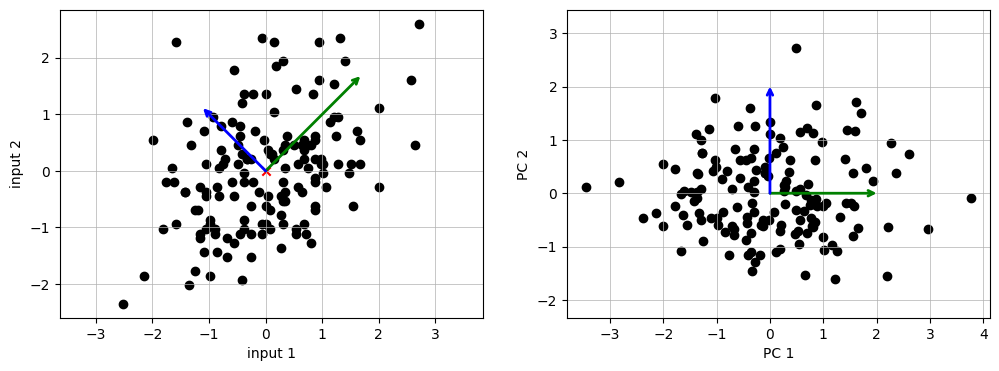

In [13]:
from sklearn.preprocessing import StandardScaler

# scale the data
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_var)

pca = PCA(n_components=2)   # define a PCA object with two PCAs (can choose more for larger data)
pca.fit(input_scaled)

print(f"pca components    = {pca.components_}")
print(f"pca var explained = {pca.explained_variance_}")

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.scatter(input_scaled[:, 0], input_scaled[:, 1], c='k')
ax.scatter(pca.mean_[0], pca.mean_[1], c='r', marker='x')
ax.annotate("", pca.mean_ + pca.components_[0] * 2 * np.sqrt(pca.explained_variance_[0]), pca.mean_,
            arrowprops=dict(color="green", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.annotate("", pca.mean_ + pca.components_[1] * 2 * np.sqrt(pca.explained_variance_[1]), pca.mean_,
            arrowprops=dict(color="blue", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"input 2"); ax.grid(lw=0.5, zorder=0); ax.axis("equal");

input_pca = pca.transform(input_scaled)

ax = plt.subplot(1, 2, 2)
ax.scatter(input_pca[:, 0], input_pca[:, 1], c="k")
ax.annotate("", [2, 0], [0, 0],
            arrowprops=dict(color="green", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.annotate("", [0, 2], [0, 0],
            arrowprops=dict(color="blue", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.set_xlabel(r"PC 1"); ax.set_ylabel(r"PC 2"); ax.grid(lw=0.5, zorder=0); ax.axis("equal");

If we scaled the data we might want to re-scale the data. The code below undoes the scaling, for both the original case (so this is just the original data), and for the PCs (which is the PC in "real" units, not that the PC itself is necessarily overly information from a physical point of view).

> NOTE: We need the `pca.mean_.reshape(1, -1)` for syntax reasons, as the inverse transform is expecting two arguments but as a "column" rather stacked as a "row" (I am not saying I agree with it, I am just doing what the routine wants).

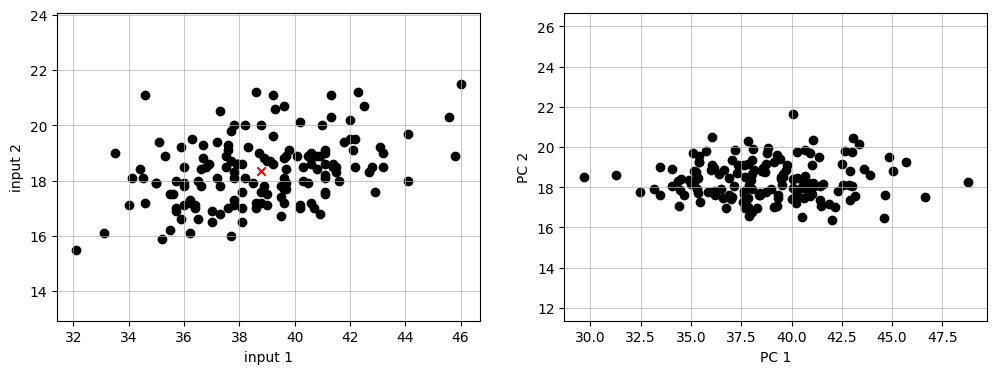

In [14]:
unscaled_mean = scaler.inverse_transform(pca.mean_.reshape(1, -1))
unscaled_pca_input = scaler.inverse_transform(input_pca)

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.scatter(input_var[:, 0], input_var[:, 1], c='k')
ax.scatter(unscaled_mean[0, 0], unscaled_mean[0, 1], c='r', marker='x')
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"input 2"); ax.grid(lw=0.5, zorder=0); ax.axis("equal");

ax = plt.subplot(1, 2, 2)
ax.scatter(unscaled_pca_input[:, 0], unscaled_pca_input[:, 1], c="k")
ax.set_xlabel(r"PC 1"); ax.set_ylabel(r"PC 2"); ax.grid(lw=0.5, zorder=0); ax.axis("equal");

## from 2d to 1d

In the above case this is essentially a co-ordinate transformation because I have two input data and I asked for 2 PCs. To sort of see what it is doing in a rather trivial (but illuminating, at least for me) way, we are going to instead ask for 1 PC. The below code does the scaling, the PCA, and re-scales as well as reverts the data.

pca components    = [[0.70710678 0.70710678]]
pca var explained = [1.4007683]


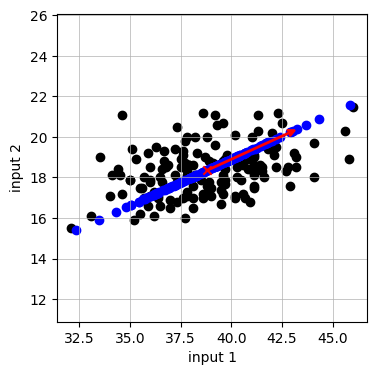

In [15]:
input_var = adelie_data[['bill_length_mm', 'bill_depth_mm']].values
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_var)
pca = PCA(n_components=1)
pca.fit(input_scaled)

print(f"pca components    = {pca.components_}")
print(f"pca var explained = {pca.explained_variance_}")

input_pca = pca.transform(input_scaled)
proj_scaled = pca.inverse_transform(input_pca)
proj = scaler.inverse_transform(proj_scaled)
unscaled_mean = scaler.inverse_transform(pca.mean_.reshape(1, -1))

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.scatter(input_var[:, 0], input_var[:, 1], c='k')
ax.scatter(proj[:, 0], proj[:, 1], c='b')
ax.scatter(unscaled_mean[0, 0], unscaled_mean[0, 1], c='r', marker='x')
ax.annotate("", scaler.inverse_transform(pca.mean_ + pca.components_ * 2 * np.sqrt(pca.explained_variance_))[0], 
            scaler.inverse_transform(pca.mean_.reshape(1, -1))[0],
            arrowprops=dict(color="red", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"input 2"); ax.grid(lw=0.5, zorder=0); ax.axis("equal");

So what is happening is that you take the data, perform the PCA with 1 PC, so this is just the green arrow previously. Then what you are doing is taking the data and **projecting** it onto the PC, i.e. onto the red line here, so the result is that you only get data on a line. While your data in the original variables is still two dimensional in the sense there are two outputs, the data could really be regarded as lower dimensional (in this case 1d), because it basically follows a line (which can be represented by one number, the length away from whatever point on the line you decide.

> NOTE: In maths speak, the line can be parameterised by one variable.

## from 4d to 2d

Well you might ask what is the point of that? So in the penguin data you have data in 4d (`bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`), so how do you visualise all the data at the same time, or highlight what are the important features? We don't have enough dimensions to represent all variables at the same time (you could do 3d plots but then you only include 3 variables at a time), but in some sense you could by doing a PCA.

The codes below does this for the whole penguin data. We first do the zeroth rule of data analysis and just do a sample plot to see what the data looks like. I don't know about you, but I can't see anything here...

loading data locally (assumes file has already been downloaded)


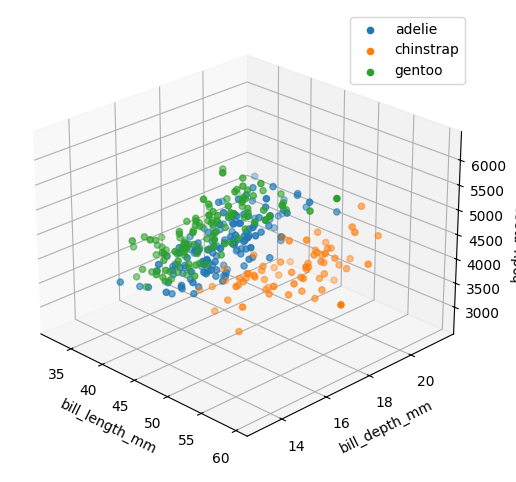

In [16]:
# read and redfine data for safety

option = "local"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

adelie_data = df.loc[df["species"] == "Adelie"]
chinst_data = df.loc[df["species"] == "Chinstrap"]
gentoo_data = df.loc[df["species"] == "Gentoo"]

fig = plt.figure(figsize=(6, 6))

key1, key2, key3 = "bill_length_mm", "bill_depth_mm", "body_mass_g"

ax = plt.axes(projection="3d")
ax.scatter(adelie_data[key1], adelie_data[key2], adelie_data[key3], label="adelie")
ax.scatter(chinst_data[key1], chinst_data[key2], chinst_data[key3], label="chinstrap")
ax.scatter(gentoo_data[key1], gentoo_data[key2], gentoo_data[key3], label="gentoo")
ax.set_xlabel(f"{key1}")
ax.set_ylabel(f"{key2}")
ax.set_zlabel(f"{key3}")
ax.grid(lw=0.5, zorder=0)
ax.legend()
ax.view_init(25, -45)

Then we do a PCA keeping 2 PCs, which results in a formally 2d data, given in a table and a 2d scatter plot below.

In [17]:
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
input_vars = df.loc[:, features].values

input_var_scaled = StandardScaler().fit_transform(input_vars)

pca = PCA(n_components=2)   # define a PCA object with two PCAs (can choose more for larger data)
pca_comp = pca.fit_transform(input_var_scaled)

pca_df = pd.DataFrame(data = pca_comp, columns = ['PC1', 'PC2'])
pca_df["species"] = df.loc[:,['species']].values  # add the variety column back on
pca_df.sample(10)                                 # this is now 2d data

,PC1,PC2,species
53,-2.441683,-0.787379,Adelie
163,1.676161,-1.174056,Gentoo
192,2.721861,0.317865,Gentoo
228,2.786532,0.634300,Gentoo
76,-1.918438,0.139111,Adelie
179,1.581489,-0.641544,Gentoo
52,-0.778815,0.723642,Adelie
286,-0.769652,0.341859,Chinstrap
287,0.381512,1.252561,Chinstrap
159,1.177041,-1.563509,Gentoo


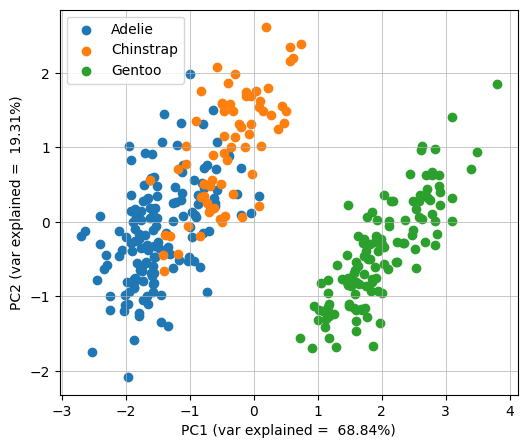

In [18]:
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(1, 2, 1)
for name in ["Adelie", "Chinstrap", "Gentoo"]:
    ax.scatter(pca_df.loc[df["species"] == name]["PC1"], 
               pca_df.loc[df["species"] == name]["PC2"], label = name)
ax.set_xlabel(f"PC1 (var explained = {pca.explained_variance_ratio_[0] * 100 : .2f}%)")
ax.set_ylabel(f"PC2 (var explained = {pca.explained_variance_ratio_[1] * 100 : .2f}%)")
ax.grid(lw=0.5, zorder=0)
ax.legend()

In [19]:
pca = PCA(n_components=4)
pca.fit_transform(input_var_scaled)
pca.components_
# pca.explained_variance_ratio_

array([[ 0.45525033, -0.40033468,  0.57601332,  0.54835019],
       [ 0.59703114,  0.79776657,  0.0022822 ,  0.08436292],
       [ 0.64430115, -0.41842724, -0.23208397, -0.59660012],
       [ 0.14552311, -0.16798597, -0.78379875,  0.57988211]])

The PCs are ranked by the variance explained, and in this case it is saying the two PCs together explain over 95% of the data variance, so that's good. We also see here that the three species of flower do form clusters, with the setosa data noticeable different from the other two, and the other two have some overlap. 

The way you might want to intrepret this is that the clustering suggests that species is a good predictor for the attributes, i.e. if you know the species, you can probably construct a model to predict the attributes, but inverting the 2 PCs in this case to your 4 original variables (because you have the mapping to go between the two representations). 

You can go the other way as well, so you could regress in PC-space, invert the model, and that gives you some representation of your regressed model in the original variables; technically in this case the complexity you would count the number of free variables, which really is 2 (in PC-space). Not going to do this here unless you want a challenge (see below for suggested exercise).

Below code outputs the raw variance and variance ratio explained by the PCs. The 3rd and 4th PC explains very little (consistent with the large variance already explained by the first two PCs), so it's probably fine dropping those.

In [20]:
var_explained = np.zeros((4, 4))
var_explained_ratio = np.zeros((4, 4))
for i in range(1, 5):
    pca = PCA(n_components=i)
    pca.fit_transform(input_var_scaled)
    for j in range(i):
        var_explained[i-1, j] = pca.explained_variance_[j]
        var_explained_ratio[i-1, j] = pca.explained_variance_ratio_[j]

print("===============================")
print("raw value of variance explained")
print("===============================")
print(var_explained)
print()
print("===============================")
print("percentage of variance explained")
print("===============================")
print(var_explained_ratio)

raw value of variance explained
[[2.76183065 0.         0.         0.        ]
 [2.76183065 0.7747822  0.         0.        ]
 [2.76183065 0.7747822  0.36630698 0.        ]
 [2.76183065 0.7747822  0.36630698 0.10881037]]

percentage of variance explained
[[0.68843878 0.         0.         0.        ]
 [0.68843878 0.19312919 0.         0.        ]
 [0.68843878 0.19312919 0.09130898 0.        ]
 [0.68843878 0.19312919 0.09130898 0.02712305]]


We can invert the mapping by convert the two PCs back to the original four real variables, and see the consequences on the data. The code below gives a demonstration of this.

In [21]:
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
input_vars = df.loc[:, features].values

# scale the data
input_var_scaled = scaler.fit_transform(input_vars)

pca = PCA(n_components=2)   # define a PCA object with two PCAs (can choose more for larger data)
pca_comp = pca.fit_transform(input_var_scaled)

proj = scaler.inverse_transform(pca.inverse_transform(pca_comp))

df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]] = proj
df.sample(10)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
278,Chinstrap,49.648978,20.499601,198.618608,4207.521753
242,Gentoo,53.765865,16.671476,222.245597,5426.730078
65,Adelie,36.056298,16.006963,190.064139,3520.626371
106,Adelie,41.278945,19.276067,187.095828,3483.874990
48,Adelie,45.178541,20.542331,189.641744,3685.347260
227,Gentoo,45.180632,14.771493,213.041413,4810.169151
293,Chinstrap,47.549296,18.663872,201.925935,4323.911532
211,Gentoo,42.696036,14.400893,209.650944,4596.800898
67,Adelie,35.482517,16.641283,186.362595,3331.061979
259,Gentoo,42.497112,14.206953,210.045458,4611.729743


----------------
# More involved exercises with this notebook

## 1) Iris data

The [iris data](https://en.wikipedia.org/wiki/Iris_flower_data_set) was originally compiled by Ronald Fisher and is generally regarded as the *hello_world* of data analysis (and machine learning as well). Do a similar analysis as the penguin data but for this dataset. You should read open the source file and go to that website to have a look and see what variables are there etc. This is available here as `iris.csv` (the link is here: https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/penguins.csv).

> NOTE: Since this is a well-known dataset, a lot of the answers you might want are actually readily found on Google.

> Random unrelated fact: cats are quite allergic to iris flowers (and quite a lot of flowers actually), so keep them away

I touched up the iris data from the [UCL repository](https://archive.ics.uci.edu/ml/datasets/iris) and dumped it out into a text file called `iris.csv`, which should be able to be read into Pandas directly. Try and explore the Iris data a bit and do some statistics/plots on it (I am not going to describe the data, you can look this up on the Wikipedia above).




## 2) A/BIC practice

> <span style="color:red">**Q.**</span> Consider applying A/BIC to the example in *03_regression* when you go back to doing linear regression (with some fix choice of data; you could use my linear/quadratic example or cook something up) instead varying the degree of the polynomial (for simplicity you could take the number of coefficients to be the measure of complexity). Graph out the A/BIC as well as contributions to the A/BIC as well to see how these change with increasing complexity.

## 3) PCA et al.

> <span style="color:red">**Q.**</span> (hard-ish) Write your own PCA code in numpy (you will need `np.cov` and the linear algebra package; the internet is your friend here). You have the right answer to check again in the form of the code above, and some data you already analysed.

> <span style="color:red">**Q.**</span> Read up what a **linear discriminant analysis (LDA)** is, how it is used, and apply it to the iris and/or the penguin data.
>
> May be useful for the next excercise should you wish to attempt it.

> <span style="color:red">**Q.**</span> (hard-ish and tedious) This is probably related **clustering algorithms** but much more primitive, and is sort of like a machine learning by hand exercise. Given the PC-mapping, consider coding up something that, when given the four attributes of the iris data, returns whether the predicted flower variety. So it's also like a multi-linear model but it gives you discrete instead of continuous outcomes.
>
> If I were to do this, I would probably chop out a proportion of data for training and testing purposes, given there are 50 entries per species of flower, probably 40 for traning and 10 for testing. I would throw in the 40 pieces of data for doing a PCA and, looking at the reuslts, cook up by hand some criteria (in PC-space) that returns some outcomes to me, such as
>
>```
>    if (data_PC1 > blah) & (data_PC1 < bleh) & (data_PC2 > blih) & (data_PC2 < bluh):
>      print(f"probably setosa")
>    elif (...)
>      print(f"probably virginica")
>    elif (...
>      print(f"probably versicolor")
>    else:
>      print(f"out of bounds, who knows?")
>```
> and pass the remaining data in and predict the flower variety, and see how well you do.
>
> For extra work, try and look up and see if `sklearn` already has something that can do this kind of thing (there probably is, and this exercise is really to get you to think algorithmically).